# Phase 3: Conduct image classification using the Neural Network approach

# Experiment 1: Construction of Simple Neural Network,
**Data augmentation for generalization purpose of training dataset,
Loading Dataset, Labels for mapping,
Model Training and Testing,
Initial random but appropriate hyper parameters,
Optimizer.
All in one pipeline to run easily. Learning rate 0.001, epochs 30, batch size 64, data augmentation, 2 hidden layers of NN**

**Step 1: Importing all necessary libraries. Will add as per requirement**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

**Step 2: Paths to dataset(which was already prepared in phase 1) and labels from class_name.txt**

In [ ]:
# Parameters
base_dir = "prepared_dataset2"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
class_labels_path = os.path.join("TinyImageNet100", "class_name.txt")
num_classes = 15
img_height, img_width = 64, 64
batch_size = 64
epochs = 30
learning_rate = 0.001
validation_split = 0.2

**Step 3: Loading class labels and lables of selected classes**

In [ ]:

# Load class labels
def load_class_labels(class_labels_path, selected_classes):
    class_labels = {}
    with open(class_labels_path, "r") as f:
        for line in f:
            class_name, *labels = line.strip().split()
            if class_name in selected_classes:
                class_labels[class_name] = " ".join(labels)
    return [class_labels[class_name] for class_name in selected_classes]

selected_classes = sorted(os.listdir(train_dir))
class_labels = load_class_labels(class_labels_path, selected_classes)

**Step 4: Function to prepare data loaders and data augmentation techniques to improve generalization of model**

In [ ]:
# Data loader function
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
         transforms.RandomRotation(20), # added
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #added
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

**Step 5: Constructing Fully Connected Neural Network naming HinaSimpleNN with 2 hidden layers**

In [ ]:
class HinaSimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(HinaSimpleNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc_layers(x)

**Step 6: Prepare data loaders, initilaizing model,loss function and optimizer(Adm)**

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model =HinaSimpleNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**Step 7: Training Model**

In [ ]:
 def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)  # Flatten images
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(train_loader.dataset))
        train_accuracies.append(100 * correct / total)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(100 * correct / total)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, train_accuracies, val_losses, val_accuracies

**Step 8: Function to plot curves and test model**

In [ ]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.show()

def test_model(model, test_loader, criterion, device, class_labels):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

**Step 9: Function to plot confusion matrix**

In [ ]:
def plot_confusion_matrix(model, test_loader, class_labels, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


**Step 10: Train,Evaluate and Saving the Model**

Epoch 1/30, Train Loss: 2.6762, Train Acc: 16.27%, Val Loss: 2.4354, Val Acc: 21.92%
Epoch 2/30, Train Loss: 2.4644, Train Acc: 20.83%, Val Loss: 2.4183, Val Acc: 22.25%
Epoch 3/30, Train Loss: 2.4192, Train Acc: 22.88%, Val Loss: 2.4523, Val Acc: 21.33%
Epoch 4/30, Train Loss: 2.3949, Train Acc: 23.06%, Val Loss: 2.3410, Val Acc: 25.67%
Epoch 5/30, Train Loss: 2.3681, Train Acc: 23.08%, Val Loss: 2.3417, Val Acc: 24.83%
Epoch 6/30, Train Loss: 2.3628, Train Acc: 23.94%, Val Loss: 2.3641, Val Acc: 22.08%
Epoch 7/30, Train Loss: 2.3376, Train Acc: 24.94%, Val Loss: 2.3527, Val Acc: 24.08%
Epoch 8/30, Train Loss: 2.3171, Train Acc: 24.79%, Val Loss: 2.3143, Val Acc: 26.08%
Epoch 9/30, Train Loss: 2.2716, Train Acc: 26.67%, Val Loss: 2.3161, Val Acc: 25.25%
Epoch 10/30, Train Loss: 2.2706, Train Acc: 26.40%, Val Loss: 2.3580, Val Acc: 24.58%
Epoch 11/30, Train Loss: 2.2605, Train Acc: 26.88%, Val Loss: 2.2620, Val Acc: 28.08%
Epoch 12/30, Train Loss: 2.2426, Train Acc: 28.02%, Val Loss: 2

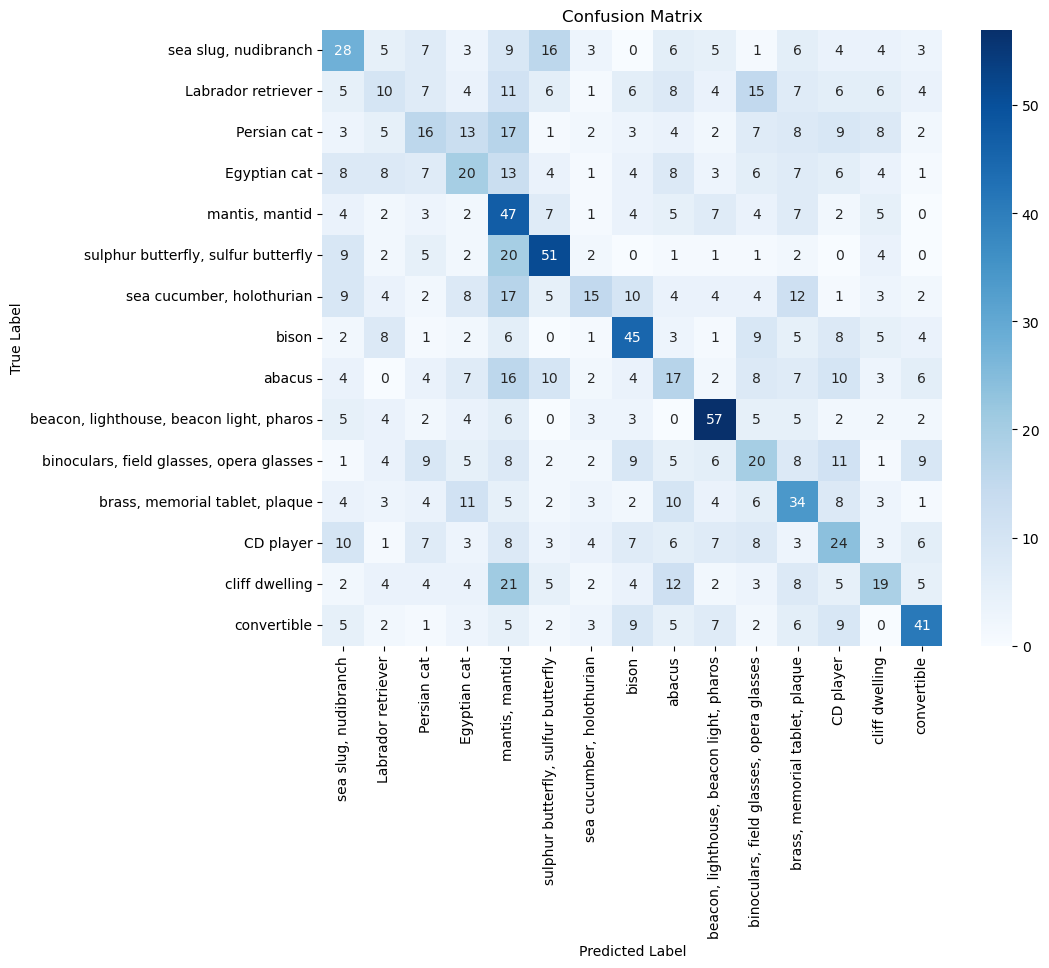

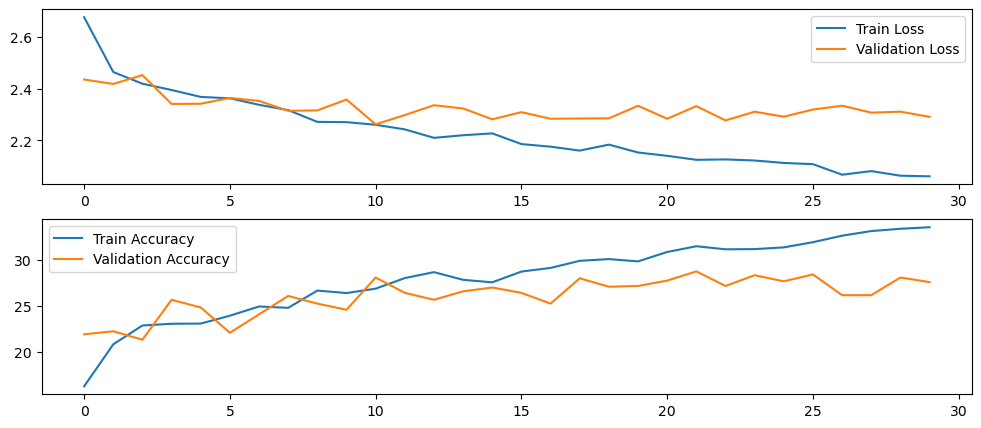

In [18]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)


# Experiment 2: increasing the number of epochs and reducing the learning rate to observe results

Epoch 1/50, Train Loss: 2.5399, Train Acc: 16.90%, Val Loss: 2.3962, Val Acc: 22.25%
Epoch 2/50, Train Loss: 2.3980, Train Acc: 22.58%, Val Loss: 2.3468, Val Acc: 25.00%
Epoch 3/50, Train Loss: 2.3413, Train Acc: 24.83%, Val Loss: 2.3106, Val Acc: 25.92%
Epoch 4/50, Train Loss: 2.2874, Train Acc: 26.40%, Val Loss: 2.2757, Val Acc: 28.67%
Epoch 5/50, Train Loss: 2.2549, Train Acc: 27.77%, Val Loss: 2.2585, Val Acc: 26.75%
Epoch 6/50, Train Loss: 2.2220, Train Acc: 29.31%, Val Loss: 2.2292, Val Acc: 28.42%
Epoch 7/50, Train Loss: 2.1856, Train Acc: 29.23%, Val Loss: 2.2454, Val Acc: 28.17%
Epoch 8/50, Train Loss: 2.1570, Train Acc: 30.94%, Val Loss: 2.2391, Val Acc: 28.67%
Epoch 9/50, Train Loss: 2.1232, Train Acc: 32.21%, Val Loss: 2.2027, Val Acc: 29.42%
Epoch 10/50, Train Loss: 2.0848, Train Acc: 32.56%, Val Loss: 2.1600, Val Acc: 31.42%
Epoch 11/50, Train Loss: 2.0796, Train Acc: 32.88%, Val Loss: 2.1838, Val Acc: 32.17%
Epoch 12/50, Train Loss: 2.0584, Train Acc: 33.21%, Val Loss: 2

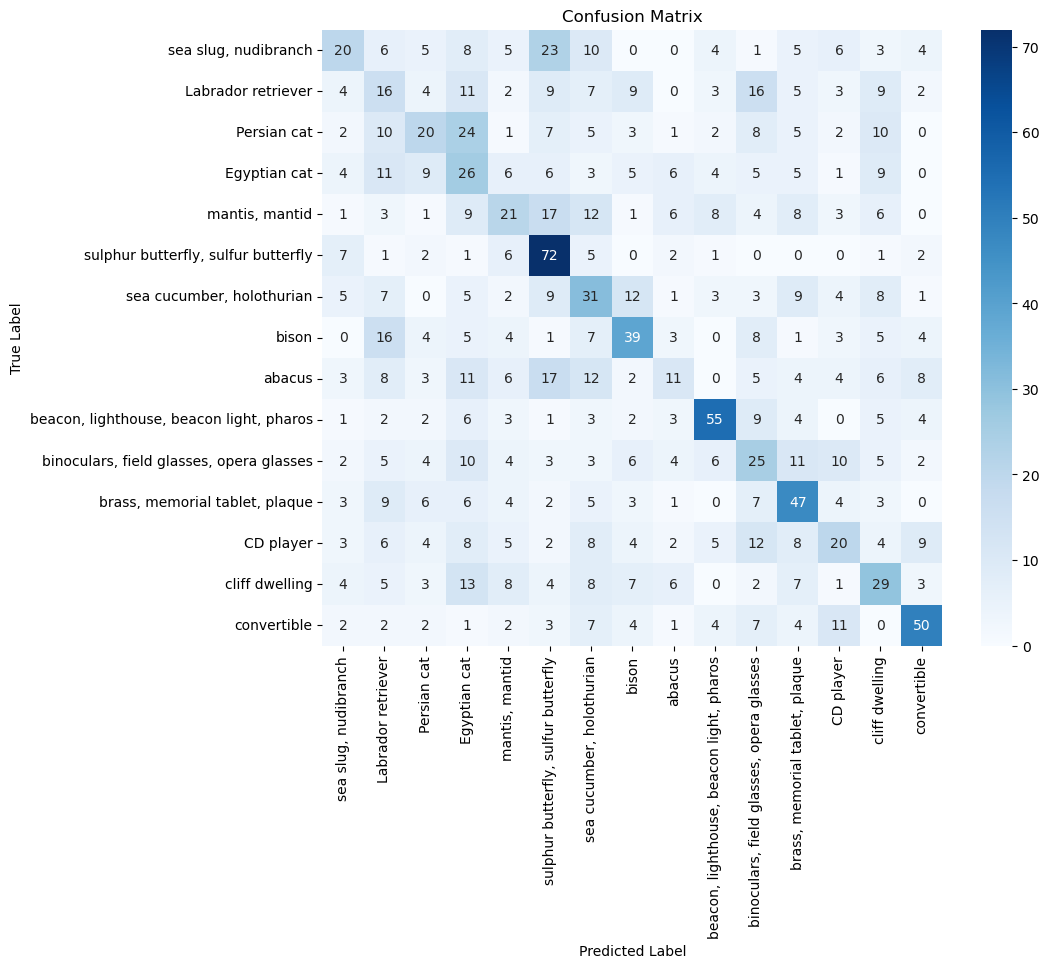

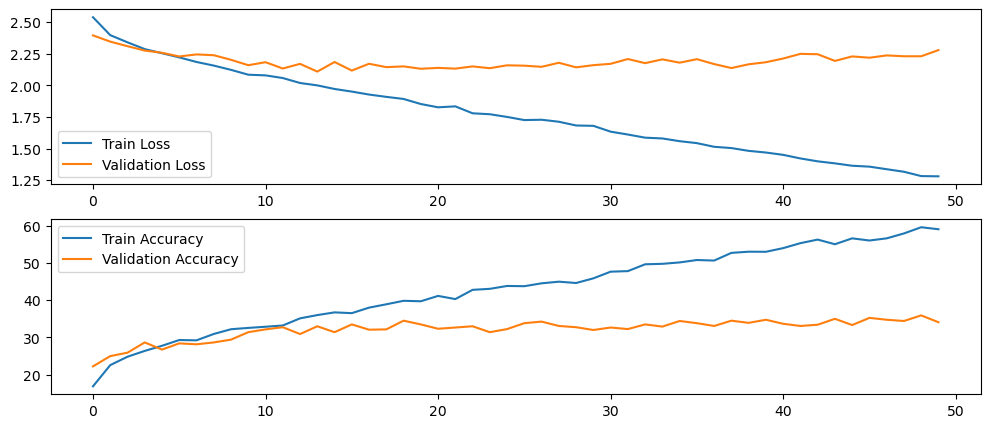

Model saved as HinaSimpleNN_model.pth


In [41]:
epochs = 50
learning_rate = 0.0001

# Data loader function
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
         transforms.RandomRotation(20), # added
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #added
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

class HinaSimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(HinaSimpleNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc_layers(x)

train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model = HinaSimpleNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)  # Flatten images
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(train_loader.dataset))
        train_accuracies.append(100 * correct / total)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(100 * correct / total)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.show()

def test_model(model, test_loader, criterion, device, class_labels):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

def plot_confusion_matrix(model, test_loader, class_labels, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Saving the Model
torch.save(model.state_dict(), "HinaSimpleNN_model.pth")
print("Model saved as HinaSimpleNN_model.pth")
